# save data to pickle

In [2]:
# # save variables to pickle
# import pickle
# filename = "variables.pickle"
# with open(filename, 'wb') as f:
#     pickle.dump({
#         'qtw_imputed': qtw_imputed,
#         'qtw_encoded': qtw_encoded
#     }, f)

# get data from pickle

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

In [4]:
with open('variables.pickle', 'rb') as f:
    pic = pickle.load(f)
qtw = pic["qtw"]

In [5]:
qtw["M6_VQ_ITT"].value_counts()

Smoking       6154
Abstinence     434
Name: M6_VQ_ITT, dtype: int64

# set column names

In [6]:
column_names = qtw.columns.values.tolist()
base_cols = [column_name for column_name in column_names if "M1" not in column_name and "M2" not in column_name and "M3" not in column_name and "M6" not in column_name]
m1_cols = base_cols + [column_name for column_name in column_names if "M1" in column_name]
m2_cols = m1_cols + [column_name for column_name in column_names if "M2" in column_name]
m3_cols = m2_cols + [column_name for column_name in column_names if "M3" in column_name]

# set up models

In [7]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso

# iterate over base, m1, m2, m3 cols to predict m6

In [8]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [9]:
results = {}

set_of_cols = {
    "base": base_cols,
    "m1": base_cols + m1_cols,
    "m2": base_cols + m1_cols + m2_cols,
    "m3": base_cols + m1_cols + m2_cols + m3_cols,
}
# xgboost params
param = {'max_depth': 8, 'eta': .3, 'objective': 'binary:logistic', "scale_pos_weight" : 1}
param['nthread'] = 4
param['eval_metric'] = ["aucpr"]
num_round = 10

In [10]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df


In [19]:

for name, cols in zip(list(set_of_cols.keys()), list(set_of_cols.values())):
    # X
    data = pd.DataFrame()
    
    print("-----")
    print(f"training {name} set of columns")
    for col in cols:
        data = pd.concat([data.reset_index(drop=True), qtw.filter(regex = col)], axis=1)
    # y
    label = qtw["M6_VQ_ITT"]
    label = pd.get_dummies(label, drop_first = True)
    # invert labelling to predict validated abstinence
    label = 1 - label
    
    # CV split
    rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    fold = 0
    results[name] = {}
    for train_index, test_index in rs.split(data):
        X_train = data.iloc[train_index, :]
        y_train = label.iloc[train_index, :]
        X_test = data.iloc[test_index, :]
        y_test = label.iloc[test_index, :]



        X_train = X_train.loc[:,~X_train.columns.duplicated()]
        
        # imputation of train set
        X_train = imputation(X_train,X_train.select_dtypes(include = "object").columns.values.tolist())
        obj_cols = X_train.select_dtypes(include = "object").columns.values.tolist()
        colnames = X_train.columns.values.tolist()
        for i in range(len(colnames)):
            for j in range(len(obj_cols)):
                if colnames[i] == obj_cols[j]:
                    colnames[i] = True
            if colnames[i] != True:
                colnames[i] = False
#         import pdb; pdb.set_trace()
        sm = SMOTENC(random_state=42, categorical_features=colnames)
        X_train, y_train = sm.fit_resample(X_train, y_train)

        # encoding
        X_train = pd.get_dummies(X_train, drop_first = True)
        X_names = X_train.columns

        X_test = X_test.loc[:,~X_test.columns.duplicated()]
        # imputation of test set
        X_test = imputation(X_test,X_test.select_dtypes(include = "object").columns.values.tolist())
        # encoding
        X_test = pd.get_dummies(X_test, drop_first = True)

#         model = EasyEnsembleClassifier(random_state = 42)
#         model = LogisticRegression(penalty = 'l1',
#                                    solver="liblinear")
        model = RandomForestClassifier(random_state = 42)
        model.fit(X_train, y_train)
        ypred = model.predict_proba(X_test)[:,1]
        yclass = model.predict(X_test)
        
        results[name][f"fold{fold}"] = {
            "precision": precision_score(yclass, y_test, average = "binary"),
            "recall":recall_score(yclass, y_test, average = "binary"), 
            "aucpr": precision_recall_curve(y_test, ypred),
            "model": model,
            "feature_names": X_names
        }
        fold +=1 

-----
training base set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Use

-----
training m1 set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Use

-----
training m2 set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Use

-----
training m3 set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/ipykernel_launcher.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Use

In [100]:
# save variables to pickle
import pickle
# filename = "./randomforest/rf_resultsv3.pickle"
# with open(filename, 'wb') as f:
#     pickle.dump(results, f)

In [20]:
for name in results.keys():
    folds = 0
    precision = 0
    recall = 0
    print(f"printing metrics of prediction model based on {name} set of cols")
    for fold in results[name].keys():
        folds+=1
        precision += results[name][fold]["precision"]
        recall += results[name][fold]["recall"]
    precision /= folds
    recall /= folds
    print(round(precision,3), round(recall,3))

printing metrics of prediction model based on base set of cols
0.188 0.17
printing metrics of prediction model based on m1 set of cols
0.277 0.259
printing metrics of prediction model based on m2 set of cols
0.414 0.365
printing metrics of prediction model based on m3 set of cols
0.535 0.408


# load results

In [73]:
feat_dict = {
    "Age_5Gp": "Age group",
    "Housing": "Type of housing",
    "Employment": "Employment status",
    "Base_CO": "Level of exhaled carbon monoxide",
    "Base_HSI": "Heaviness of smoking index",
    "Base_CpdGp": "Daily cigarette consumption group",
    "Base_Cpd": "Daily cigarette consumption",
    "Base_Age_weekly_smoking": "Age of first weekly smoking",
    "Base_QA_time": "Time of last quit attempt:\n within the past month",
    "Base_Ready": "Planned quit date",
    "Base_QConfidence": "Perceived confidence of quitting",
    "Base_QRMethod_6": "Method to quit or reduce smoking previously:\n use nicotine replacement therapy",
#     M1 (Baseline and following 1-month features)
    "M1_Q": "M1 Self-reported past 7-day\n point prevalence abstinence",
    "M1_Cpd": "M1 Daily cigarette consumption",
    "M1_QA_Num": "M1 Number of quit attempts",
    "M1_R50": "M1 Daily cigarette consumption reduction by\n >=50% of baseline level",
    "M1_QReason_1": "M1 Method to quit or reduce smoking during the study:\n commitment to quit",
    "M1_QReason_4": "M1 Method to quit or reduce smoking during the study:\n other reasons",
    "M1_QReason_9": "M1 Method to quit or reduce smoking during the study:\n family members’ health",
    "M1_QReason_12": "M1 Method to quit or reduce smoking during the study:\n others’ encouragement/pressure",
    "M1_Withdrawal_3": "M1 Withdraw symptoms:\n cannot sleep well",
    "M1_Withdrawal_5": "M1 Withdraw symptoms:\n weight gain",
    "M1_Withdrawal_8": "M1 Withdraw symptoms:\n insomnia",
    "M1_Withdrawal_10": "M1 Withdraw symptoms:\n other symptoms",
#     M2 (M1 and following 2-month features)
    "M2_Q": "M2 Self-reported past 7-day\n point prevalence abstinence",
    "M2_Cpd": "M2 Daily cigarette consumption",
    "M2_QA": "M2 Quit attempt after joining the study",
    "M2_QA_acc": "M2 Quit attempt after joining the study (accumulated)",
    "M2_R50": "M2 Reduce daily cigarette consumption by\n >=50% of baseline level",
#     M3 (M2 and following 3-month features)
    "M3_Q": "M3 Self-reported past 7-day\n point prevalence abstinence",
    "M3_Cpd": "M3 Daily cigarette consumption",
    "M3_QA": "M3 Quit attempt after joining the study",
    "M3_R50": "M3 Reduce daily cigarette consumption by\n >=50% of baseline level"

}

In [74]:
feat_dict = pd.DataFrame([feat_dict.keys(), feat_dict.values()])

In [75]:
feat_dict = feat_dict.transpose()

In [102]:
with open('./logit/logit_resultsv3.pickle', 'rb') as f:
    results = pickle.load(f)

# PRAUC

In [21]:
import matplotlib.colors as mcolors
from sklearn.metrics import auc
import numpy as np

# recall_df = np.array([])
# precision_df = np.array([])

for name in results.keys():
    aucpr = 0
    prec = 0
    rec = 0
    fscore = 0
    fold_num = 0
    for fold in results[name].keys():
        fold_num += 1
        (precision, recall, thresholds) = results[name][fold]["aucpr"]
        aucpr += auc(recall, precision)
        precision = results[name][fold]["precision"]
        recall = results[name][fold]["recall"]
        fscore += 2 * precision * recall / (precision + recall)
        prec += results[name][fold]["precision"]
        rec += results[name][fold]["recall"]
    aucpr /= fold_num
    prec /= fold_num
    rec /= fold_num
    fscore /= fold_num
    print(f"{name} set of features aucpr {fold_num}fold-cv is {round(aucpr,3)}, precision is {round(prec, 3)}, recall is {round(rec, 3)}, fscore is {round(fscore, 3)}")

base set of features aucpr 5fold-cv is 0.127, precision is 0.188, recall is 0.17, fscore is 0.177
m1 set of features aucpr 5fold-cv is 0.211, precision is 0.277, recall is 0.259, fscore is 0.266
m2 set of features aucpr 5fold-cv is 0.311, precision is 0.414, recall is 0.365, fscore is 0.386
m3 set of features aucpr 5fold-cv is 0.412, precision is 0.535, recall is 0.408, fscore is 0.461


0.38038316826824325


Text(0, 0.5, 'Precision')

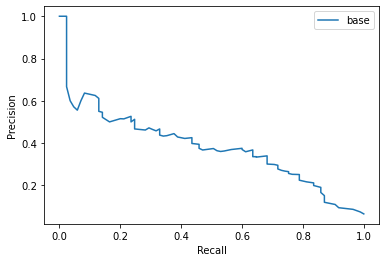

In [22]:
precision, recall, thresholds = results["m3"]["fold0"]["aucpr"]
plt.plot(recall, precision)
print(auc(recall, precision))
plt.legend(results.keys())
plt.xlabel("Recall")
plt.ylabel("Precision")
#     plt.savefig("./xgboost/aucpr.png", dpi = 200)

# XGBoost feature importance

<Figure size 1440x2880 with 0 Axes>

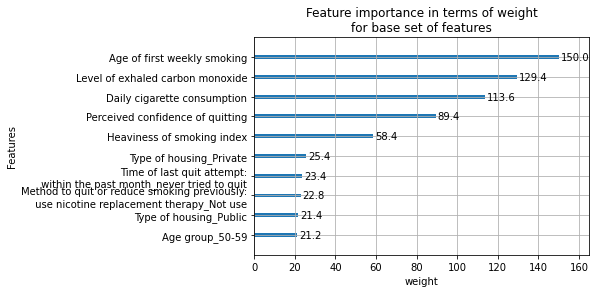

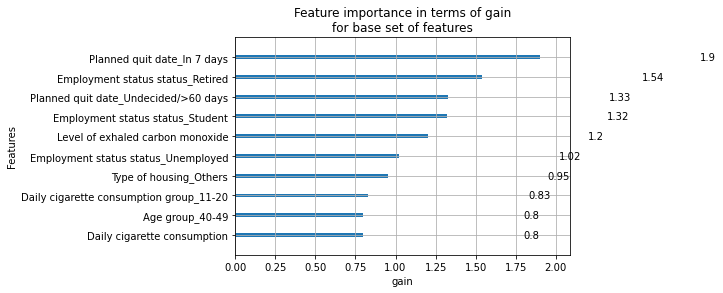

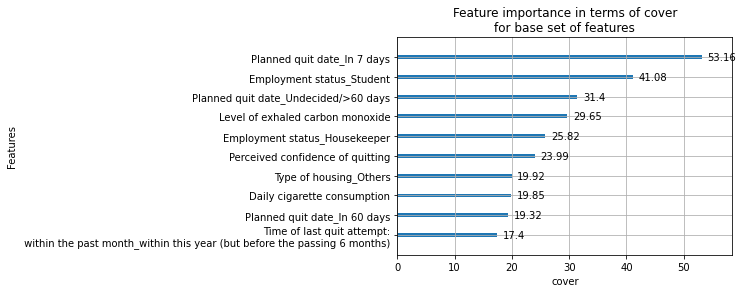

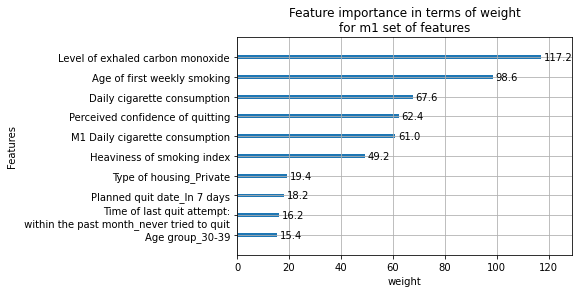

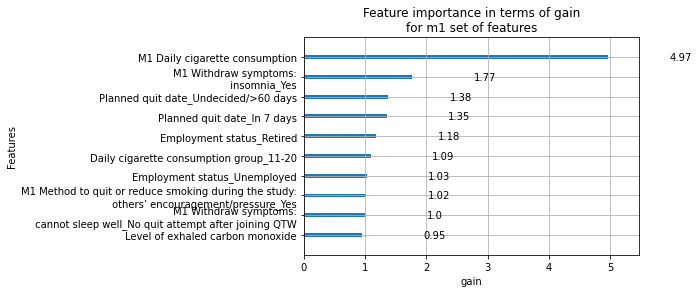

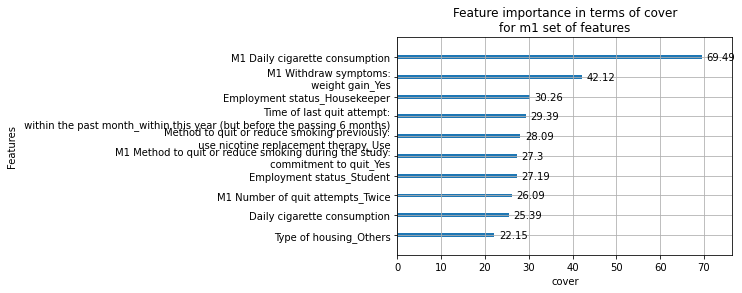

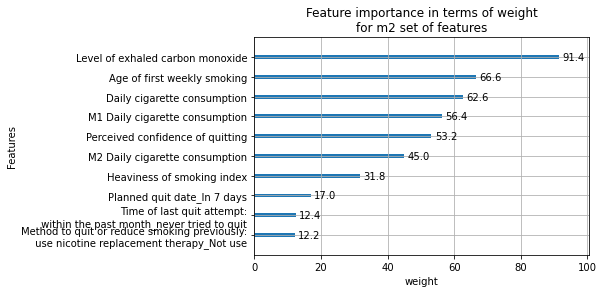

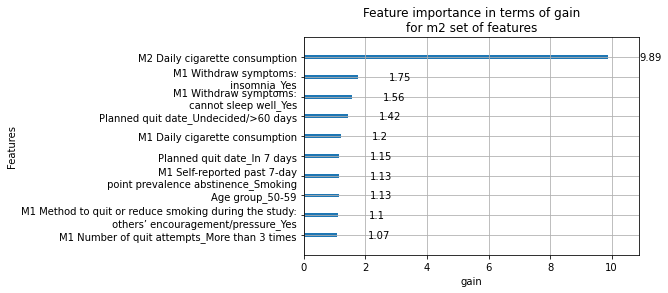

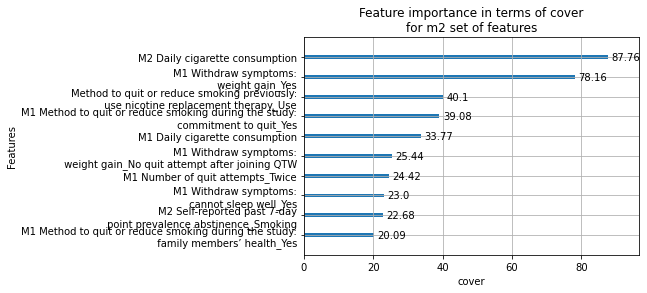

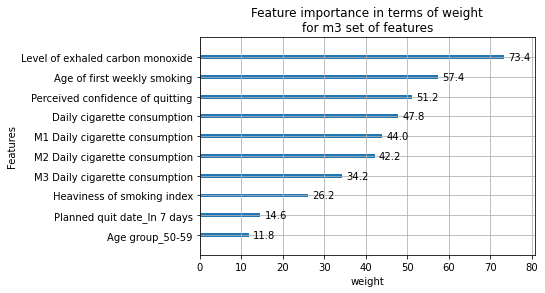

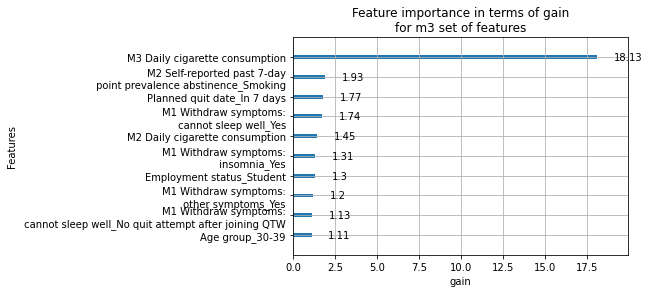

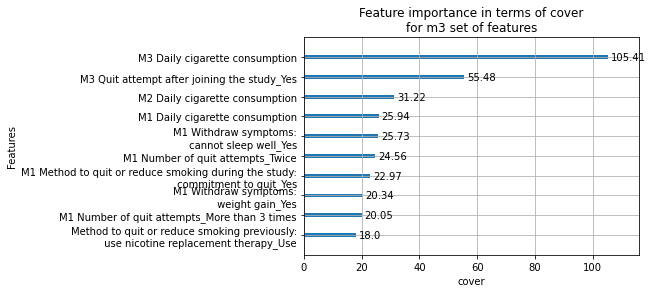

In [82]:
# not sure if easy ensemble has any function to output feature importance
plt.figure(figsize=(20,40))
for name in ['base', 'm1', 'm2', 'm3']:
    importance = {}
    fold_num = 0
    for importance_type in ["weight", 'gain', "cover"]:
        for fold in results[name].keys():
            # Get the importance dictionary (by gain) from the booster
            importance_holder = results[name][fold]["model"].get_score(importance_type=importance_type)
            for key, value in list(zip(importance_holder.keys(), importance_holder.values())):
                if key not in importance.keys():
                    importance[key] = 0
                importance[key] += value
#             import pdb; pdb.set_trace()
            fold_num += 1

        # round off score to 2 decimal places
        oldkeys = list(importance.keys())
        for key in oldkeys:
#             print(key)
            importance[key] /= fold_num
            importance[key] = round(importance[key],2)
            match_length = 0
            match_index = 0
            for j in range(len(feat_dict)):
                found = key.find(feat_dict.iloc[j, 0])
                if found != -1 and len(feat_dict.iloc[j, 0]) > match_length:
                    match_length = len(feat_dict.iloc[j, 0])
                    match_index = j
                    # replace with long form
                    
#             print(key, "->", feat_dict.iloc[match_index, 1])
            newkey = key.replace(feat_dict.iloc[match_index, 0], 
                                feat_dict.iloc[match_index, 1])
            importance[newkey] = importance[key]
            del importance[key]
            # change key names
        xgb.plot_importance(importance, 
                            importance_type = importance_type, 
                            max_num_features = 10,
                            xlabel = importance_type,
                            title = f"Feature importance in terms of {importance_type}\nfor {name} set of features")
        plt.savefig(f"./xgboost/feature_importance_{name}_{importance_type}.png", dpi=200, bbox_inches='tight')

# random forest MDI feature importance

base
fold0
fold1
fold2
fold3
fold4
m1
fold0
fold1
fold2
fold3
fold4
m2
fold0
fold1
fold2
fold3
fold4
m3
fold0
fold1
fold2
fold3
fold4


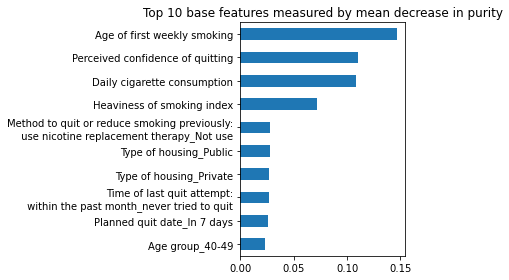

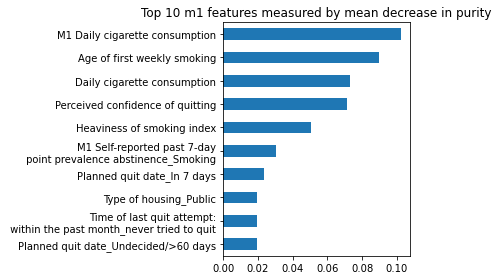

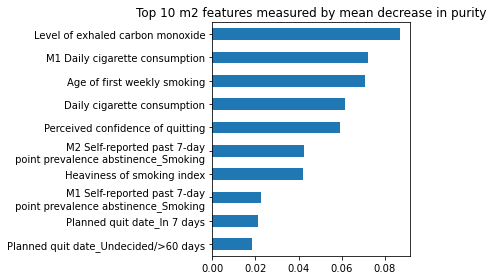

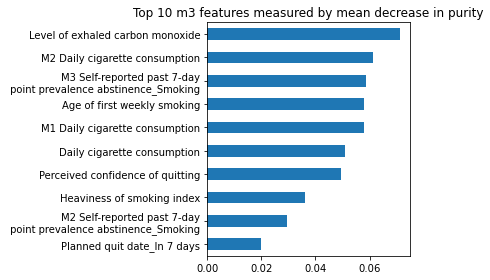

In [77]:
from matplotlib.transforms import Bbox
for feature_set in results.keys():
    print(feature_set)
    mdi = pd.DataFrame([])
    for fold in results[feature_set].keys():
        print(fold)
        # feature names
        x = results[feature_set][fold]['feature_names'].tolist()
        # convert X_names matches with to feat_dict
        for i in range(len(x)):
            match_length = 0
            match_index = "x"
            for j in range(len(feat_dict)):
                found = x[i].find(feat_dict.iloc[j, 0])
                if found != -1 and len(feat_dict.iloc[j, 0]) > match_length:
                    match_length = len(feat_dict.iloc[j, 0])
                    match_index = j
                    # replace with long form
#                     print(x[i], feat_dict.iloc[j, 0], found)            
            x[i] = x[i].replace(feat_dict.iloc[match_index, 0], 
                                feat_dict.iloc[match_index, 1])
        # feature importance, MDI
        mdi_onefold = pd.Series(results[feature_set][fold]['model'].feature_importances_, index = x)
#         if feature_set == "m2":
#             import pdb; pdb.set_trace()
        mdi = pd.concat([mdi, mdi_onefold], axis = 1)
    
#     mdi.set_index(x)
    mdi = mdi.sum(axis = 1) / 5
    mdi = mdi.sort_values(ascending = True)[-11:-1]
    
    fig, ax = plt.subplots()
    ax = mdi.plot.barh()
    ax.set_title(f"Top 10 {feature_set} features measured by mean decrease in purity")
    ax.figure.tight_layout()
    def full_extent(ax, pad=0.0):
        """Get the full extent of an axes, including axes labels, tick labels, and
        titles."""
        # For text objects, we need to draw the figure first, otherwise the extents
        # are undefined.
        ax.figure.canvas.draw()
        items = ax.get_xticklabels() + ax.get_yticklabels() 
    #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
        items += [ax, ax.title]
        bbox = Bbox.union([item.get_window_extent() for item in items])

        return bbox.expanded(1.0 + pad, 1.0 + pad)
    extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"./randomforest/MDI_{feature_set}v3.png", bbox_inches = extent)